In [20]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from transformers import TFBertModel,TFBertForSequenceClassification,BertTokenizerFast,BertForSequenceClassification
import keras
from transformers import create_optimizer
import pandas as pd
import string
from keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from transformers import create_optimizer
import pickle
import matplotlib.pyplot as plt

In [2]:
data_id = "imdb"
dataset = load_dataset(data_id)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [3]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [4]:
def preprocess_function(examples):
    return tokenizer(examples["text"],padding=True,max_length=512,truncation=True)

In [5]:
dataset=dataset.map(preprocess_function,batched=True)

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [7]:
tf_train_dataset = dataset["train"].to_tf_dataset(
    columns=["input_ids","token_type_ids","attention_mask","label"],
    shuffle=True,
    batch_size=2
)

tf_val_dataset = dataset["test"].to_tf_dataset(
    columns=["input_ids","token_type_ids","attention_mask","label"],
    shuffle=True,
    batch_size=2
)


In [8]:
def swap_positions(dataset):
    return {
        "input_ids":dataset["input_ids"],
        "token_type_ids":dataset["token_type_ids"],
        "attention_mask":dataset["attention_mask"],
        "labels":dataset["label"]
    }

In [9]:
tf_train_dataset = tf_train_dataset.map(swap_positions)
tf_val_dataset = tf_val_dataset.map(swap_positions)

In [10]:
model_id = "bert-base-uncased"
model = TFBertForSequenceClassification.from_pretrained(model_id,num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
num_epochs = 3
BATCH_SIZE = 4
batch_per_epoch = int(len(dataset["train"])//BATCH_SIZE)
total_train_steps = int(batch_per_epoch*num_epochs)
print("num_epochs :{}".format(num_epochs))
print("batch_per_epoch :{}".format(batch_per_epoch))
print("total_train_steps :{}".format(total_train_steps))
opt,scheduler = create_optimizer(init_lr=2e-5,num_train_steps=total_train_steps,num_warmup_steps=0)

num_epochs :3
batch_per_epoch :6250
total_train_steps :18750


In [12]:
model.compile(optimizer=opt,metrics=["accuracy"])

In [13]:
history=model.fit(tf_train_dataset,validation_data=tf_val_dataset,epochs=3,batch_size=32)

Epoch 1/3
12500/12500 [==============================] - 2370s 188ms/step - loss: 0.2374 - accuracy: 0.9040 - val_loss: 0.2133 - val_accuracy: 0.9118
Epoch 2/3
12500/12500 [==============================] - 2387s 191ms/step - loss: 0.0820 - accuracy: 0.9733 - val_loss: 0.1797 - val_accuracy: 0.9409
Epoch 3/3
12500/12500 [==============================] - 3883s 311ms/step - loss: 0.0594 - accuracy: 0.9833 - val_loss: 0.1797 - val_accuracy: 0.9409


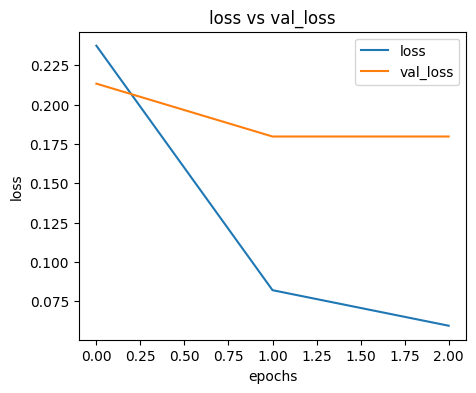

In [32]:
plt.figure(figsize=(5,4))
plt.title('loss vs val_loss')
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(["loss","val_loss"])
plt.show()

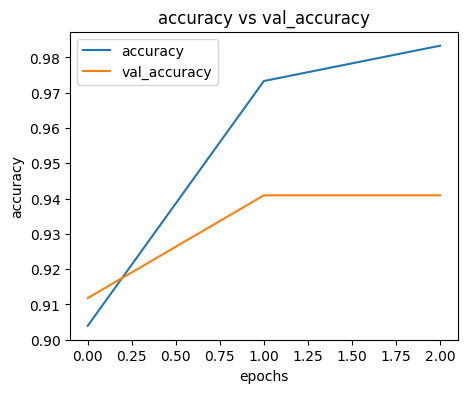

In [33]:
plt.figure(figsize=(5,4))
plt.title('accuracy vs val_accuracy')
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(["accuracy","val_accuracy"])
plt.show()

### Validate Model

In [48]:
class_labels = ["negetive","positive"]

In [69]:
review_text = ["This movie looks very integresting and a great job","Movie is too length and not at all good"]
inputs =tokenizer(review_text,padding=True,return_tensors="tf")
logits = model(**inputs).logits
result = np.argmax(logits,axis=1)
for i,val in enumerate(result):
    print("review is -> {}".format(class_labels[val]))

review is -> positive
review is -> negetive
